#### 问题分析：中国未来十年新能源汽车的发展，其实最终还是落脚在新能源汽车的政策、销量和一些基础设施的发展上，而针对政策等非数值型结果，实际上是不太好分析的，而针对于销量、基础设施等拥有每一年的数据的指标，我们是可以轻松将其定义并建模的，因此本文选用了中国新能源汽车产量、销量和新能源汽车充电站作为预测的项目，因此这几个指标从某种意义上能够代表新能源汽车的发展情况

对于预测，由于数据只有按年的走势情况，我们只能选用一些常规的时间序列预测模型，没办法使用一些对数据量要求较大的机器学习深度学习神经网络模型，而数据是按年的，不存在季节性走势，所以本文选取了ARIMA模型进行分析，通过差分保证时间序列的平稳，然后再使用AR和MA模型预测结果

### 新能源汽车的产量预测

In [1]:
import pandas as pd
## 导入会使用到的库
%config InlineBackend.figure_format = 'retina'
%matplotlib inline    
import seaborn as sns 
sns.set(font= "simhei",style="whitegrid",font_scale=1.6)
import matplotlib
matplotlib.rcParams['axes.unicode_minus']=False # 解决坐标轴的负号显示问题
## 导入需要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import plotly.express as px
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from pyod.models.knn import KNN

## 忽略提醒
import warnings
warnings.filterwarnings("ignore")

df1 = pd.read_excel('2010-2022新能源汽车产量、销量.xlsx')[:-3]
df1.index = df1.年
df1

,年,产量（万辆）,销量（万辆）,数据来源,来源网址,Unnamed: 5
年,,,,,,
2010,2010,0.72,0.49,中华人民共和国中央政府、德邦证券,http://www.gov.cn/gzdt/2011-01/18/content_1787...,http://pdf.dfcfw.com/pdf/H3_AP2020010313734370...
2011,2011,0.84,0.82,中国汽车工业协会,http://www.caam.org.cn/chn/3/cate_17/con_50669...,NaN
2012,2012,1.26,1.28,中国汽车工业协会,http://www.caam.org.cn/chn/8/cate_83/con_50858...,NaN
2013,2013,1.75,1.76,中国汽车工业协会,http://www.caam.org.cn/chn/3/cate_16/con_51120...,NaN
2014,2014,7.85,7.48,中国汽车工业协会,http://www.caam.org.cn/chn/3/cate_16/con_51443...,NaN
2015,2015,34.05,33.11,工信部,https://www.miit.gov.cn/gxsj/tjfx/zbgy/qc/art/...,NaN
2016,2016,51.7,50.70,发改委,https://www.ndrc.gov.cn/fggz/cyfz/zcyfz/201702...,NaN
2017,2017,79.4,77.70,工信部,https://www.miit.gov.cn/gxsj/tjfx/zbgy/qc/art/...,NaN
2018,2018,127.05,125.62,工信部,https://www.miit.gov.cn/gxsj/tjfx/zbgy/qc/art/...,NaN


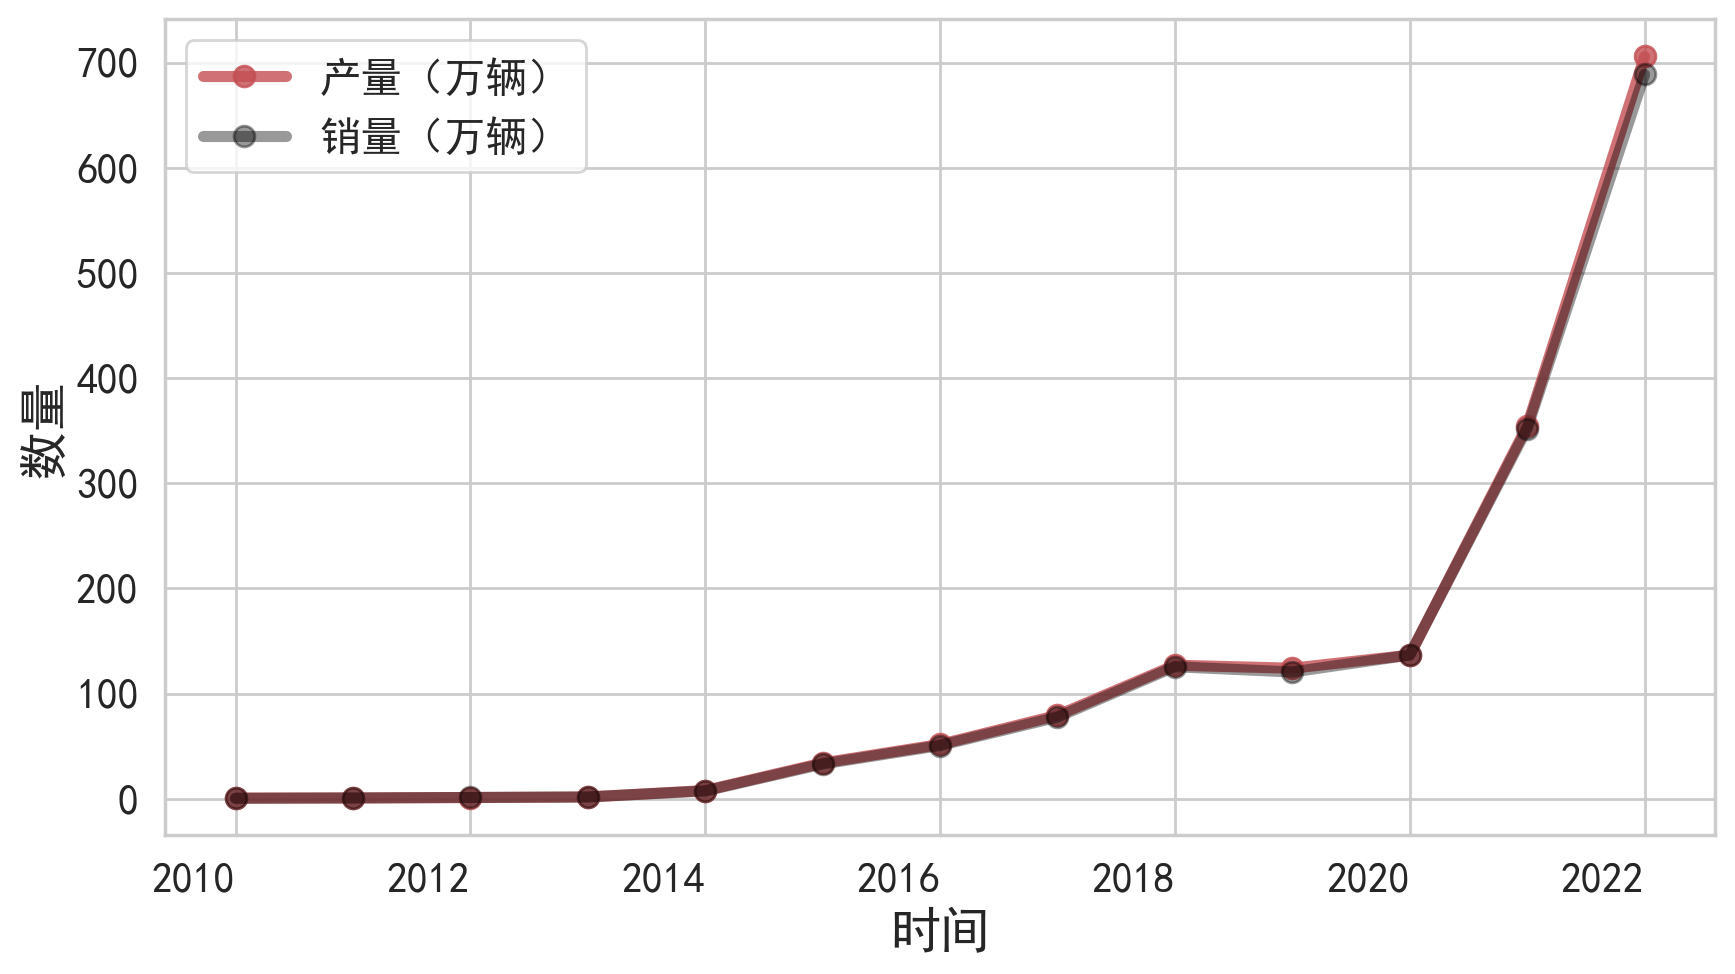

In [2]:
fig=plt.figure(figsize=(20,10))#调整画图空间的大小
df1['产量（万辆）'].plot(kind = "line",figsize = (10,6),linestyle='-',marker='.',color='r',label='产量（万辆）',alpha=0.8,linewidth=4,markersize=15)
df1['销量（万辆）'].plot(kind = "line",figsize = (10,6),linestyle='-',marker='.',color='black',label='销量（万辆）',alpha=0.4,linewidth=4,markersize=15)


fig.autofmt_xdate()#防止x轴上的数据重叠，自动调整。
plt.xlabel('时间',size=18)
plt.xticks(rotation=0)
plt.ylabel('数量',size=18)
plt.legend(fontsize=15)
plt.tick_params(labelsize=15)
#plt.savefig('产销量折线图对比.png',dpi=500)

### 突变点检测（KNN）：主要是给出产量快速变化的转折点的数学依据（以销量为依据）
依次计算每个样本点与它最近的K个样本的平均距离，再利用计算的距离与阈值进行比较，如果大于阈值，则认为是异常点。优点是不需要假设数据的分布，缺点是仅可以找出全局异常点，无法找到局部异常点。


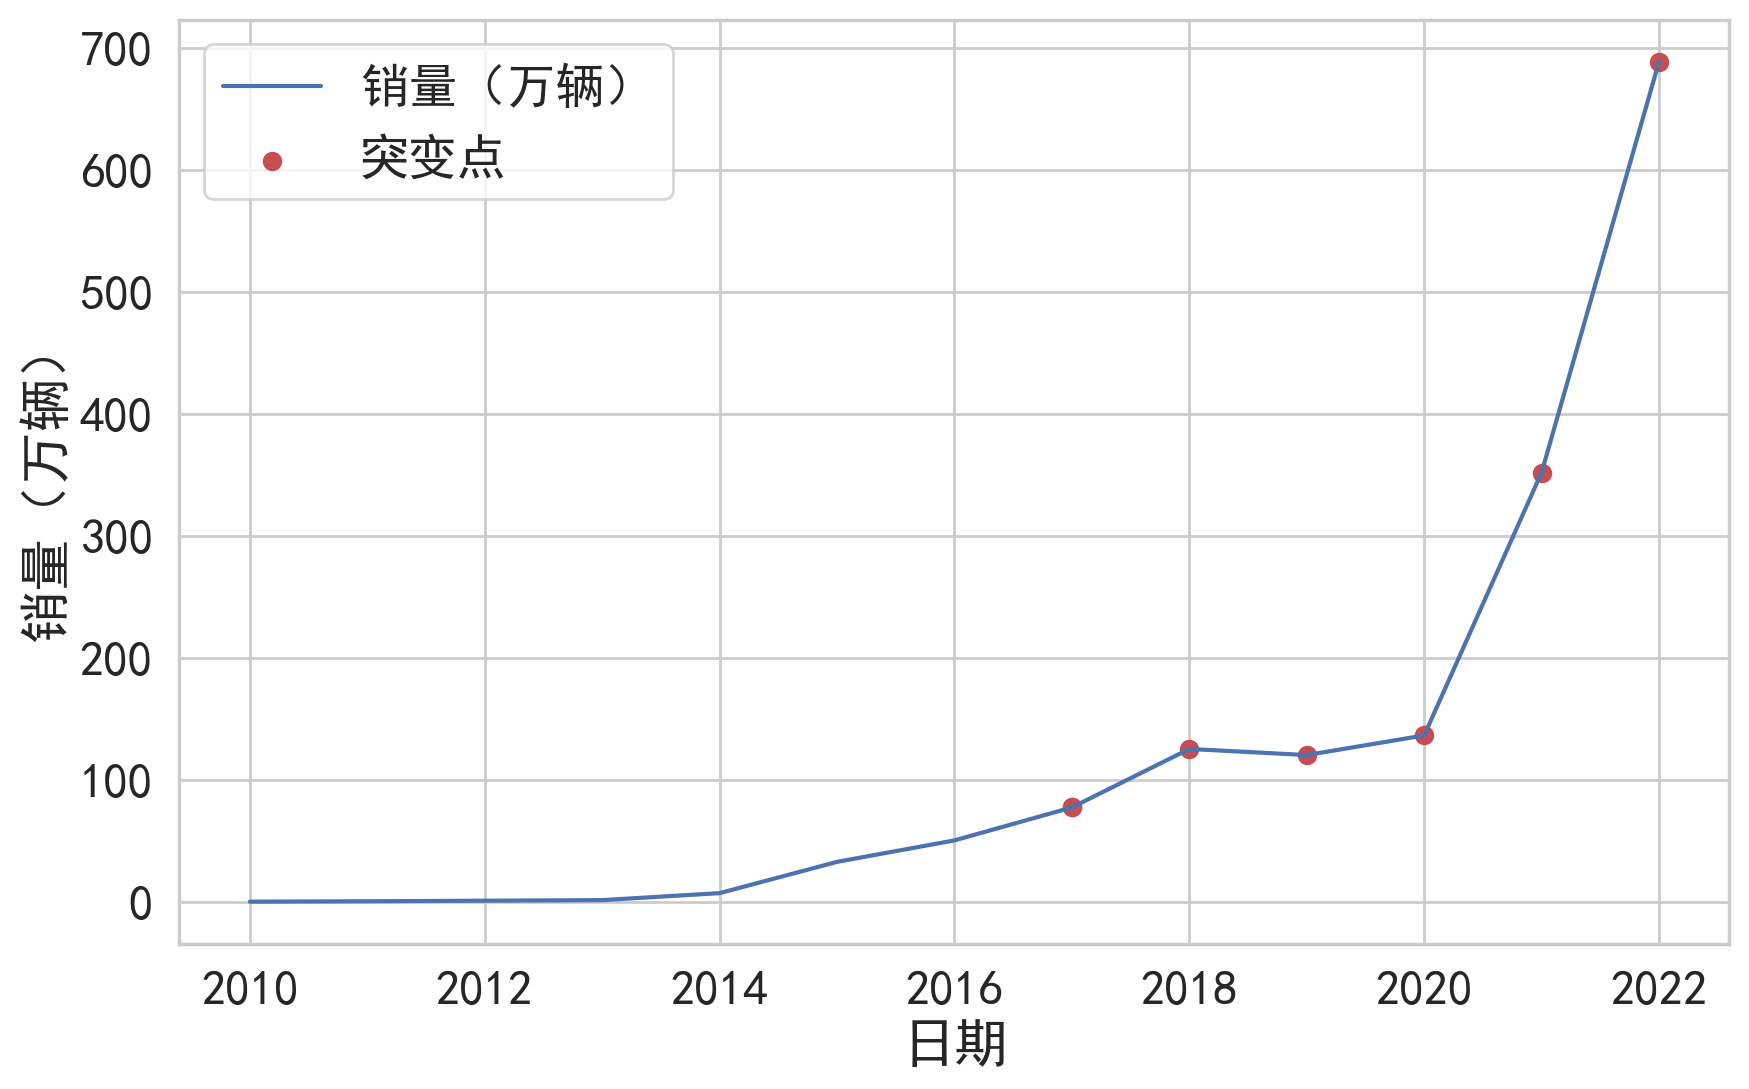

In [3]:
from pyod.models.knn import KNN

t = df1['销量（万辆）']

clf = KNN( method='mean', n_neighbors=10, )
clf.fit(t.values.reshape(-1,1))
# 返回训练数据上的分类标签 (0: 正常值, 1: 异常值)
y_train_pred = clf.labels_
# 返回训练数据上的异常值 (分值越大越异常)
y_train_scores = clf.decision_scores_

ls = []
for i,o in zip(t,y_train_scores):
    ls.append([i,o])
ls.sort(key=lambda x:x[1])
top5 = [i[0] for i in ls[::-1][:6]]

l = t.values.tolist()
index = []
for i in top5:
    index.append(l.index(i))

t.plot(kind = "line",figsize = (10,6)) #颜色,matplotlib
plt.xticks(rotation=0)
plt.xlabel("日期")
plt.ylabel("销量（万辆）")
for i in index:
    plt.scatter(i,t.values[i],c='r')
plt.scatter(i,t.values[i],c='r',label='突变点')
plt.legend()
#plt.savefig('突变点检测.png',dpi=500)
plt.show()

ls = []
for i in top5:
    ls.append(t[t==i].index[0])
pd.DataFrame(ls,columns=['date']).to_excel('突变点日期.xlsx')

在后续的分析中，由于产量和销量的走势存在极大的相似性，因此本文只考虑对销量进行预测，因为销量相对于产量能够更加反应新能源汽车的发展情况，国民喜欢，购买量就会高，发展就会好
* 其中一个问题是，根据突变点分析，我们发现整个销量变化最大的地方在最新的几年里，也就是2015年到2022年，而评价时间序列模型的一个常规方法是，将时间序列的后半段作为测试，前半段作为训练。而在本文中，由于时间序列比较短，并且变化较大的主要集中在后半段，如果将后半段作为测试，那么模型将无法捕捉到整个序列中这种变化的信息，进而造成评价模型产生较大偏差，因此，这里将不考虑进行模型评价，直接进行建模
* 而在ARIMA模型中，一个比较重要的地方在于确定ARIMA模型的参数，主要包括差分的阶数I，AR和MA模型的阶数p和q，而针对短序列数据，顶多进行一阶差分，数据几乎就会平稳，所以我们先执行adf统计检验，如果不平稳就进行一阶差分
* p和q的阶数确定主要通过模型的aic指标进行确定，因为数据较少不存在训练耗时问题，所以我们选择分别迭代p和q从1到4，选取aic最小值作为最优的ARIMA模型，然后输处预测结果

Test Statistic: 4.823772
p-value: 1.000000
min aci: (0, 1, 3)


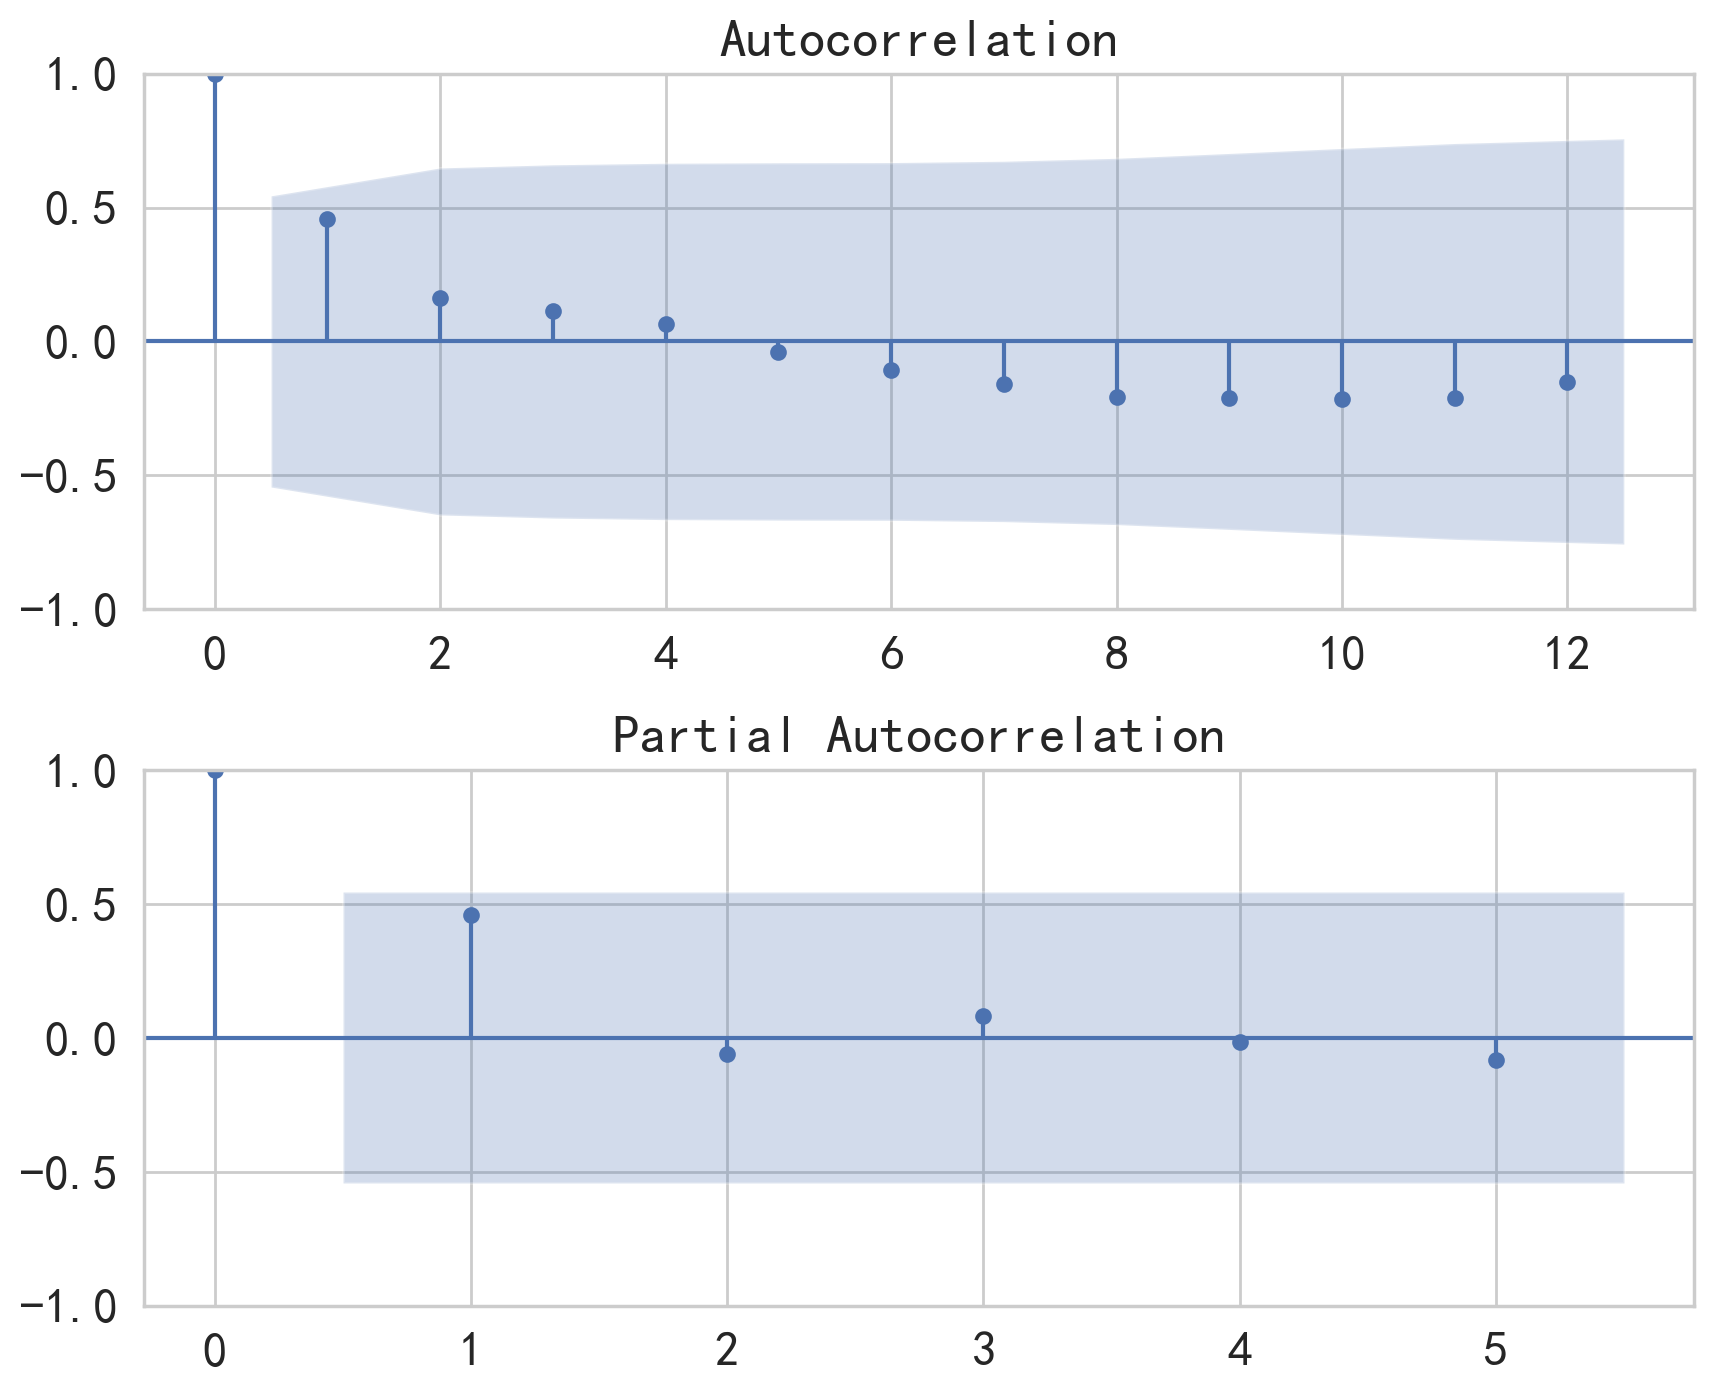

In [4]:
dataset = df1['销量（万辆）']
data_origin = dataset.copy()

# 2. 使用adf测试数据是否稳定，如果不稳定进行一阶差分，并打印差分前和差分后的数据图。
result = adfuller(dataset)
print("Test Statistic: %f" % result[0])
print("p-value: %f" % result[1])


    # 3. 对处理后数据进行归一化，打印归一化后的图。
scaler = MinMaxScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(dataset.values.reshape(-1, 1)))


# 4. 通过AIC确定ARIMA参数，打印原始数据和差分后数据的自相关系数图和偏自相关系数图，打印确定参数后的残差图。
aic_values = {}
for p in range(4):
    for q in range(4):
        try:
            model = ARIMA(scaled_data, order=(p, 1, q))
            result = model.fit()
            aic_values[(p, 1, q)] = result.aic
        except:
            continue

min_aic = min(aic_values, key=aic_values.get)
print("min aci:", min_aic)



fig, axes = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(scaled_data, ax=axes[0])
plot_pacf(scaled_data, ax=axes[1],lags=5)
plt.subplots_adjust(hspace=0.3)
#plt.savefig(f'销量自相关偏自相关图.png',dpi=500)
plt.show()


# 5. 使用ARIMA模型进行预测，打印预测值和真实值的对比图，计算模型RMSE和MAPE指标。
train_size = len(scaled_data)
train_data = scaled_data[:train_size]
model = ARIMA(train_data, order=(30,1,30))
result = model.fit()
predictions = scaler.inverse_transform(result.forecast(steps=10).values.reshape(1,-1))


针对销量ARIMA模型，最优p d q分别为0,1,3.因为adf检验发现时间序列不平稳，所以进行了差分

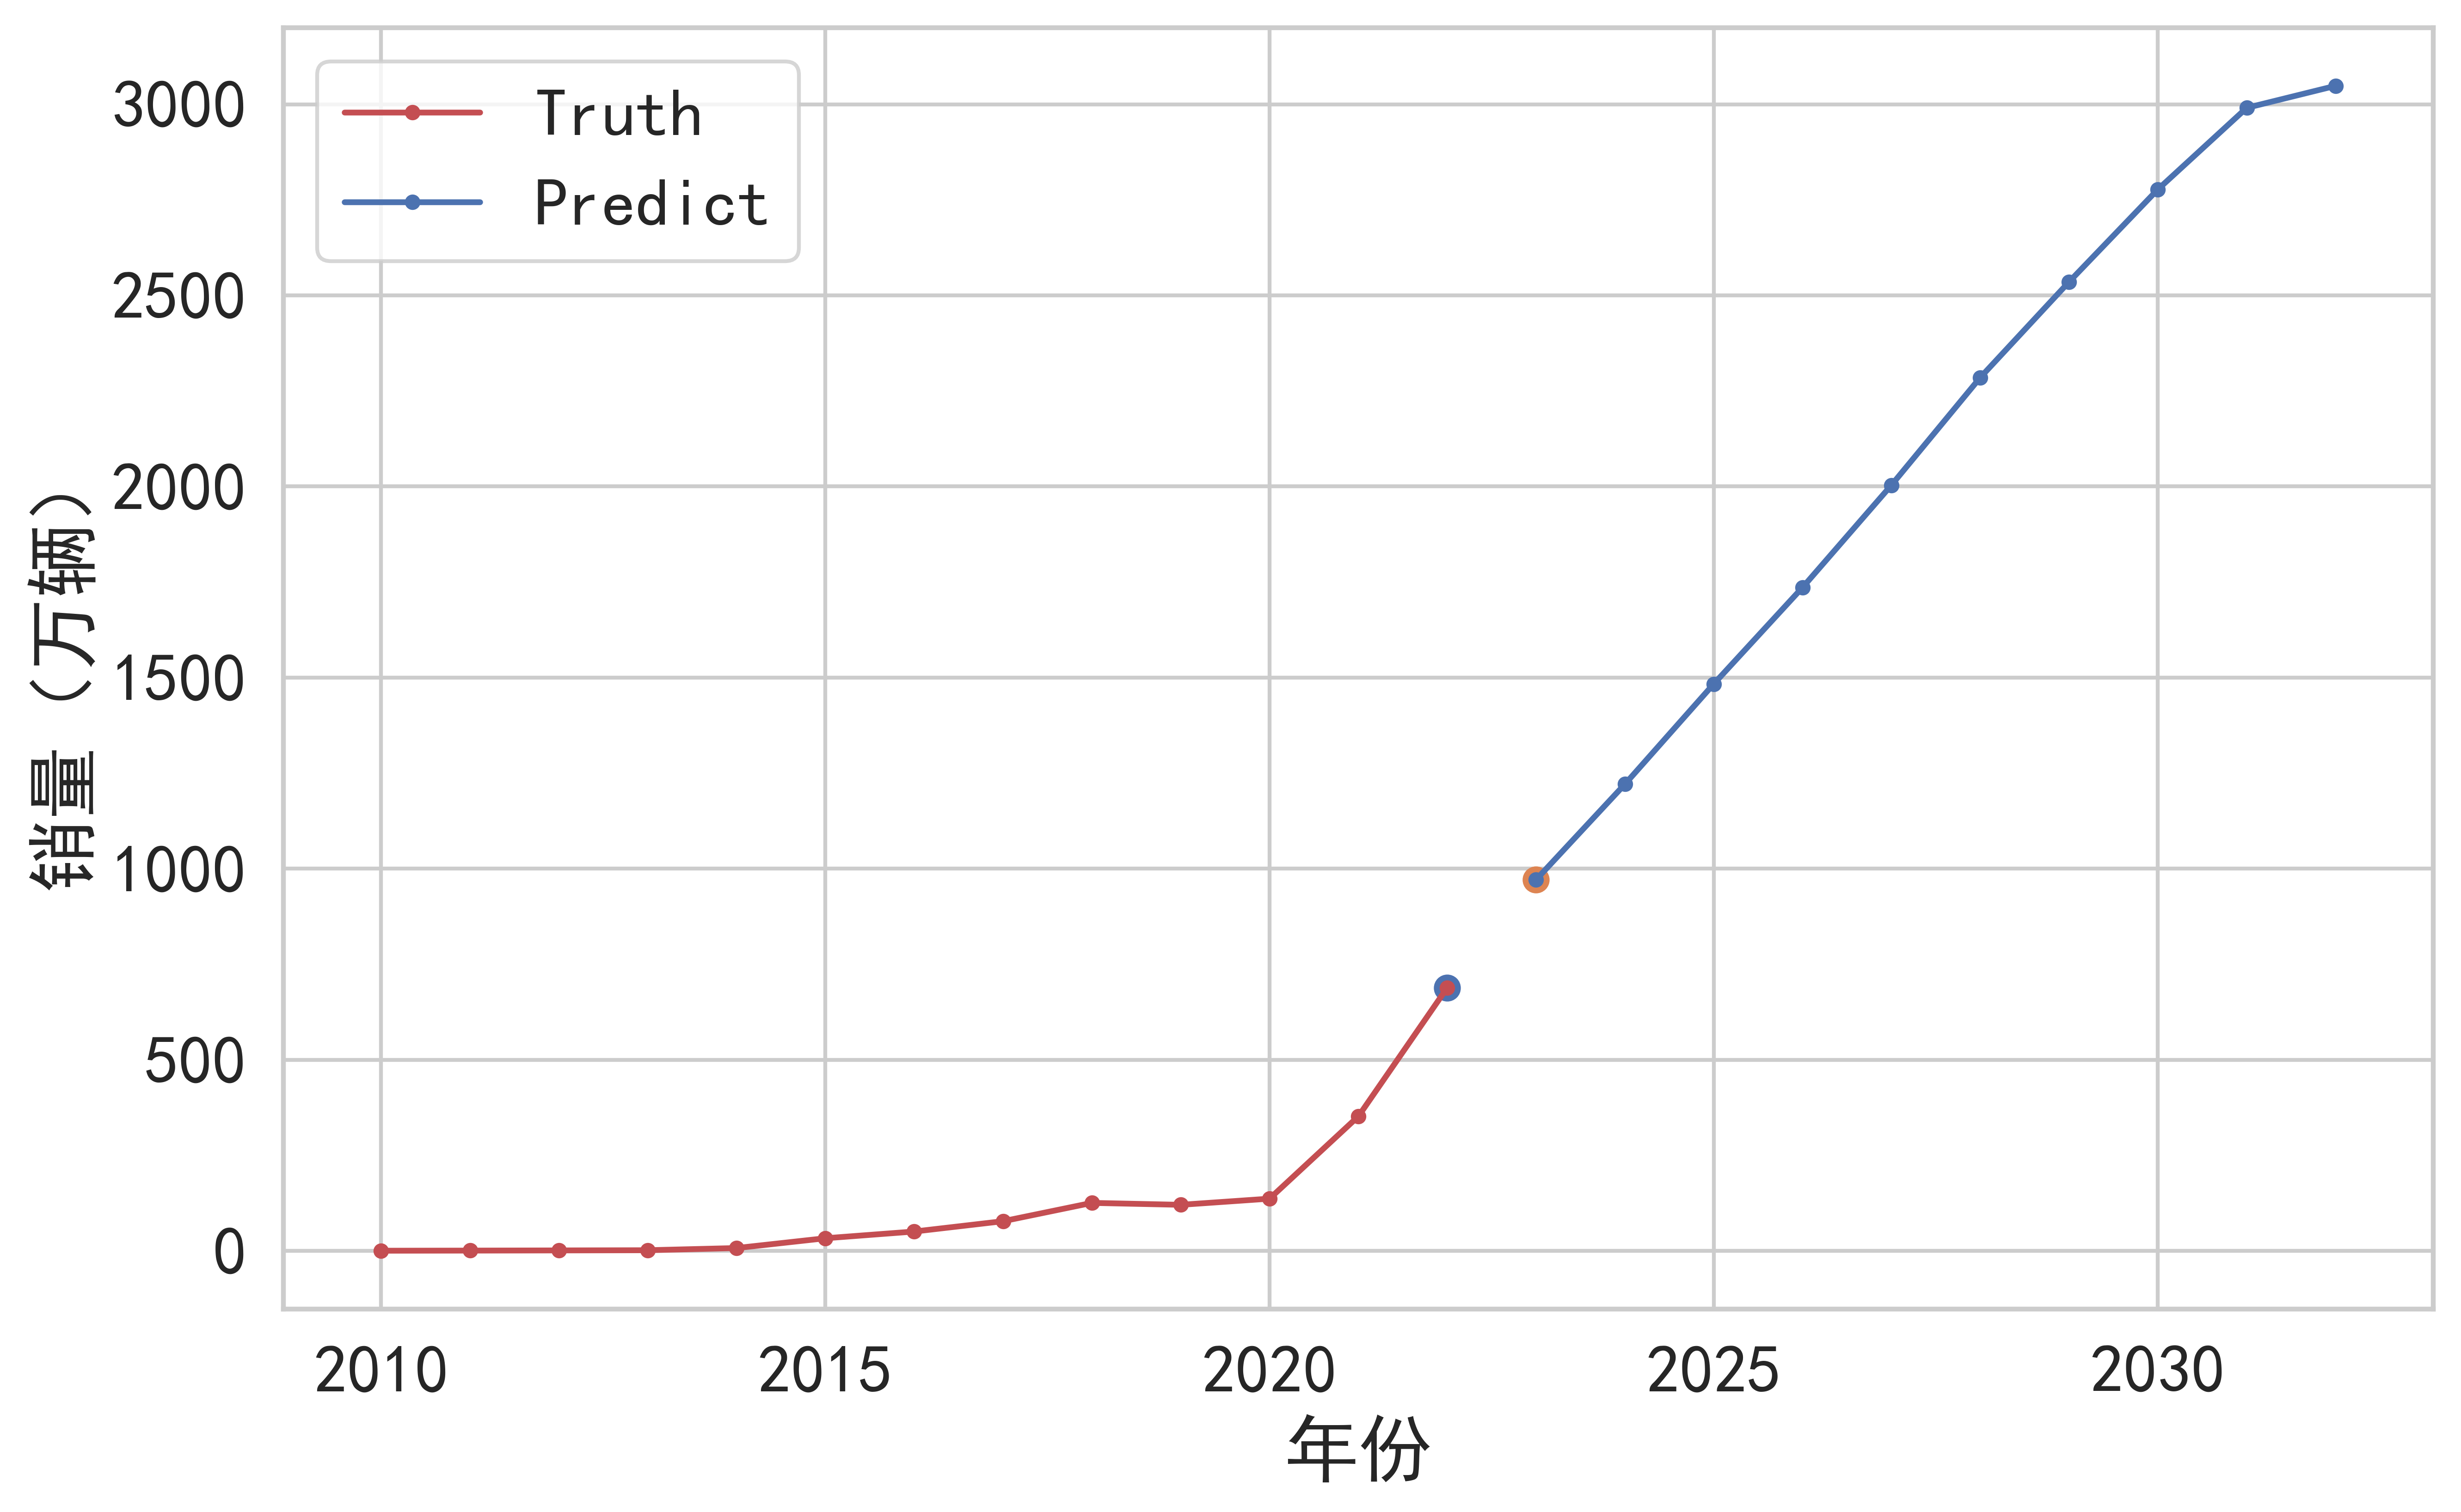

In [5]:
plt.figure(dpi=300,figsize=(10,6))
plt.plot(dataset.index,dataset.values, '-',label='Truth',linestyle='-',marker='.',color='r')
plt.scatter(dataset.index[-1],dataset.values[-1])

plt.plot(range(2023,2033),predictions[0],'--',label='Predict',linestyle='-',marker='.',color='b')
plt.scatter(2023,predictions[0][0])
plt.xlabel('年份')
plt.ylabel('销量（万辆）')
plt.legend()
plt.savefig('销量预测结果.png',dpi=500)
plt.show()

### 充电站数量预测

In [6]:
df2 = pd.read_excel('2016-2022公共充电桩（直流、交流、交直流一体）数量.xlsx')[:7]
df2.index = df2['年份']

In [7]:
df2.columns

Index(['年份', '公共类充电桩数量（万）', '直流充电桩（万）', '交流充电桩（万）', '交直流一体充电桩（万）', '数据来源',
       ' '],
      dtype='object')

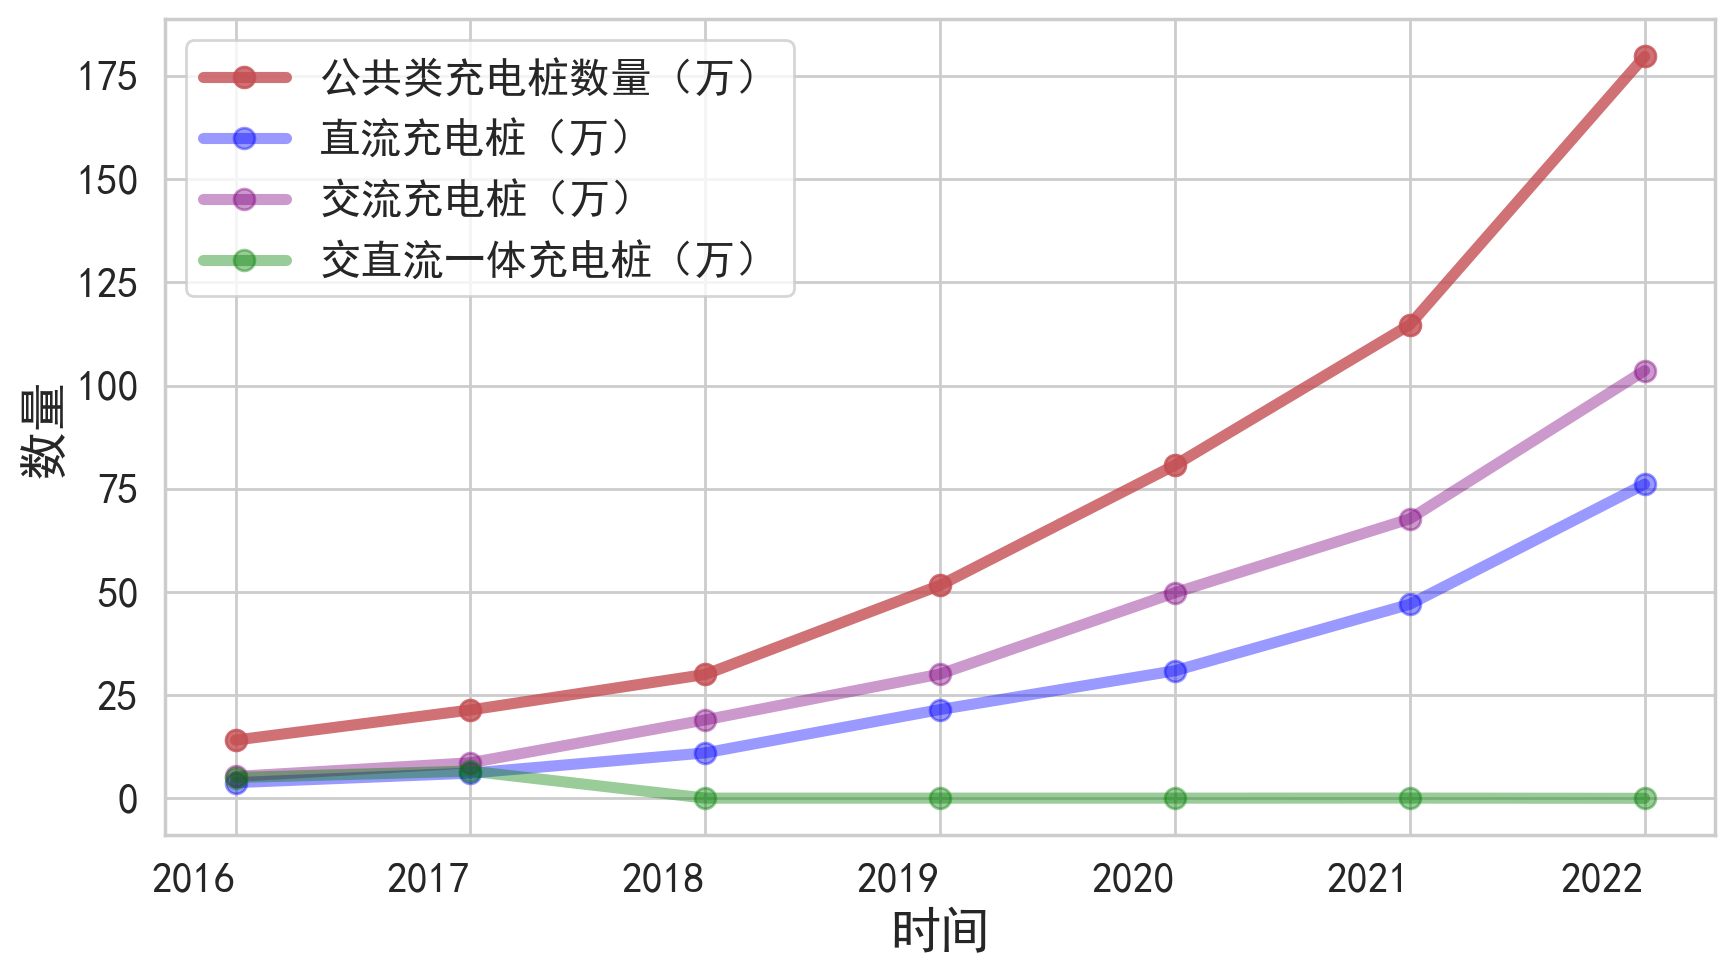

In [8]:
fig=plt.figure(figsize=(20,10))#调整画图空间的大小
df2['公共类充电桩数量（万）'].plot(kind = "line",figsize = (10,6),linestyle='-',marker='.',color='r',label='公共类充电桩数量（万）',alpha=0.8,linewidth=4,markersize=15)
df2['直流充电桩（万）'].plot(kind = "line",figsize = (10,6),linestyle='-',marker='.',color='blue',label='直流充电桩（万）',alpha=0.4,linewidth=4,markersize=15)
df2['交流充电桩（万）'].plot(kind = "line",figsize = (10,6),linestyle='-',marker='.',color='purple',label='交流充电桩（万）',alpha=0.4,linewidth=4,markersize=15)
df2['交直流一体充电桩（万）'].plot(kind = "line",figsize = (10,6),linestyle='-',marker='.',color='green',label='交直流一体充电桩（万）',alpha=0.4,linewidth=4,markersize=15)


fig.autofmt_xdate()#防止x轴上的数据重叠，自动调整。
plt.xlabel('时间',size=18)
plt.xticks(rotation=0)
plt.ylabel('数量',size=18)
plt.legend(fontsize=15)
plt.tick_params(labelsize=15)
plt.savefig('充电站折线图对比.png',dpi=500)

#### 针对充电站，我们只进行所有充电桩的建模

Test Statistic: 7.835749
p-value: 1.000000
min aci: (1, 1, 0)


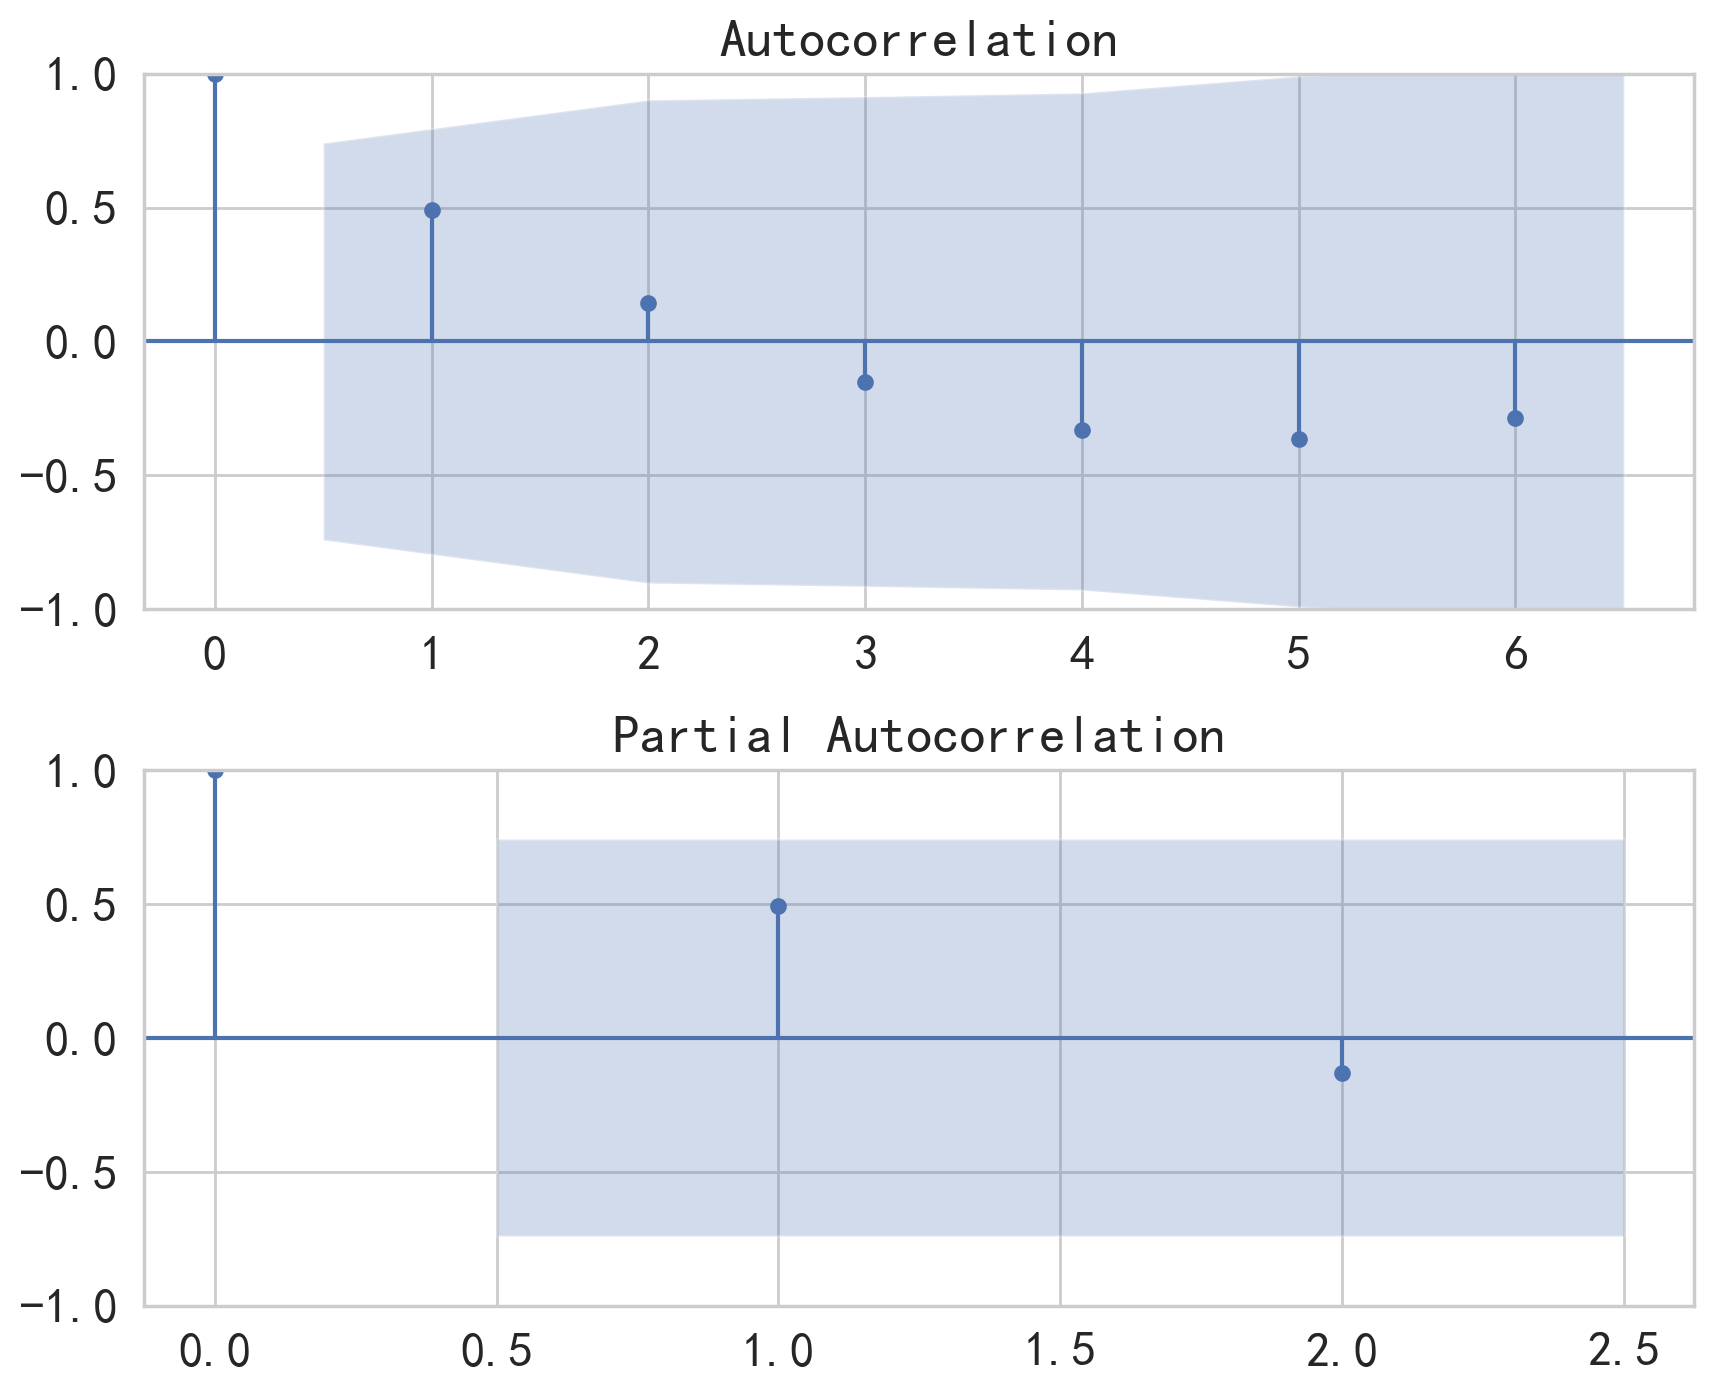

In [9]:
dataset = df2['公共类充电桩数量（万）']
data_origin = dataset.copy()

# 2. 使用adf测试数据是否稳定，如果不稳定进行一阶差分，并打印差分前和差分后的数据图。
result = adfuller(dataset)
print("Test Statistic: %f" % result[0])
print("p-value: %f" % result[1])


    # 3. 对处理后数据进行归一化，打印归一化后的图。
scaler = MinMaxScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(dataset.values.reshape(-1, 1)))


# 4. 通过AIC确定ARIMA参数，打印原始数据和差分后数据的自相关系数图和偏自相关系数图，打印确定参数后的残差图。
aic_values = {}
for p in range(4):
    for q in range(4):
        try:
            model = ARIMA(scaled_data, order=(p, 1, q))
            result = model.fit()
            aic_values[(p, 1, q)] = result.aic
        except:
            continue

min_aic = min(aic_values, key=aic_values.get)
print("min aci:", min_aic)



fig, axes = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(scaled_data, ax=axes[0])
plot_pacf(scaled_data, ax=axes[1],lags=2)
plt.subplots_adjust(hspace=0.3)
#plt.savefig(f'充电站自相关偏自相关图.png',dpi=500)
plt.show()


# 5. 使用ARIMA模型进行预测，打印预测值和真实值的对比图，计算模型RMSE和MAPE指标。
train_size = len(scaled_data)
train_data = scaled_data[:train_size]
model = ARIMA(train_data, order=(30,1,30))
result = model.fit()
predictions = scaler.inverse_transform(result.forecast(steps=10).values.reshape(1,-1))


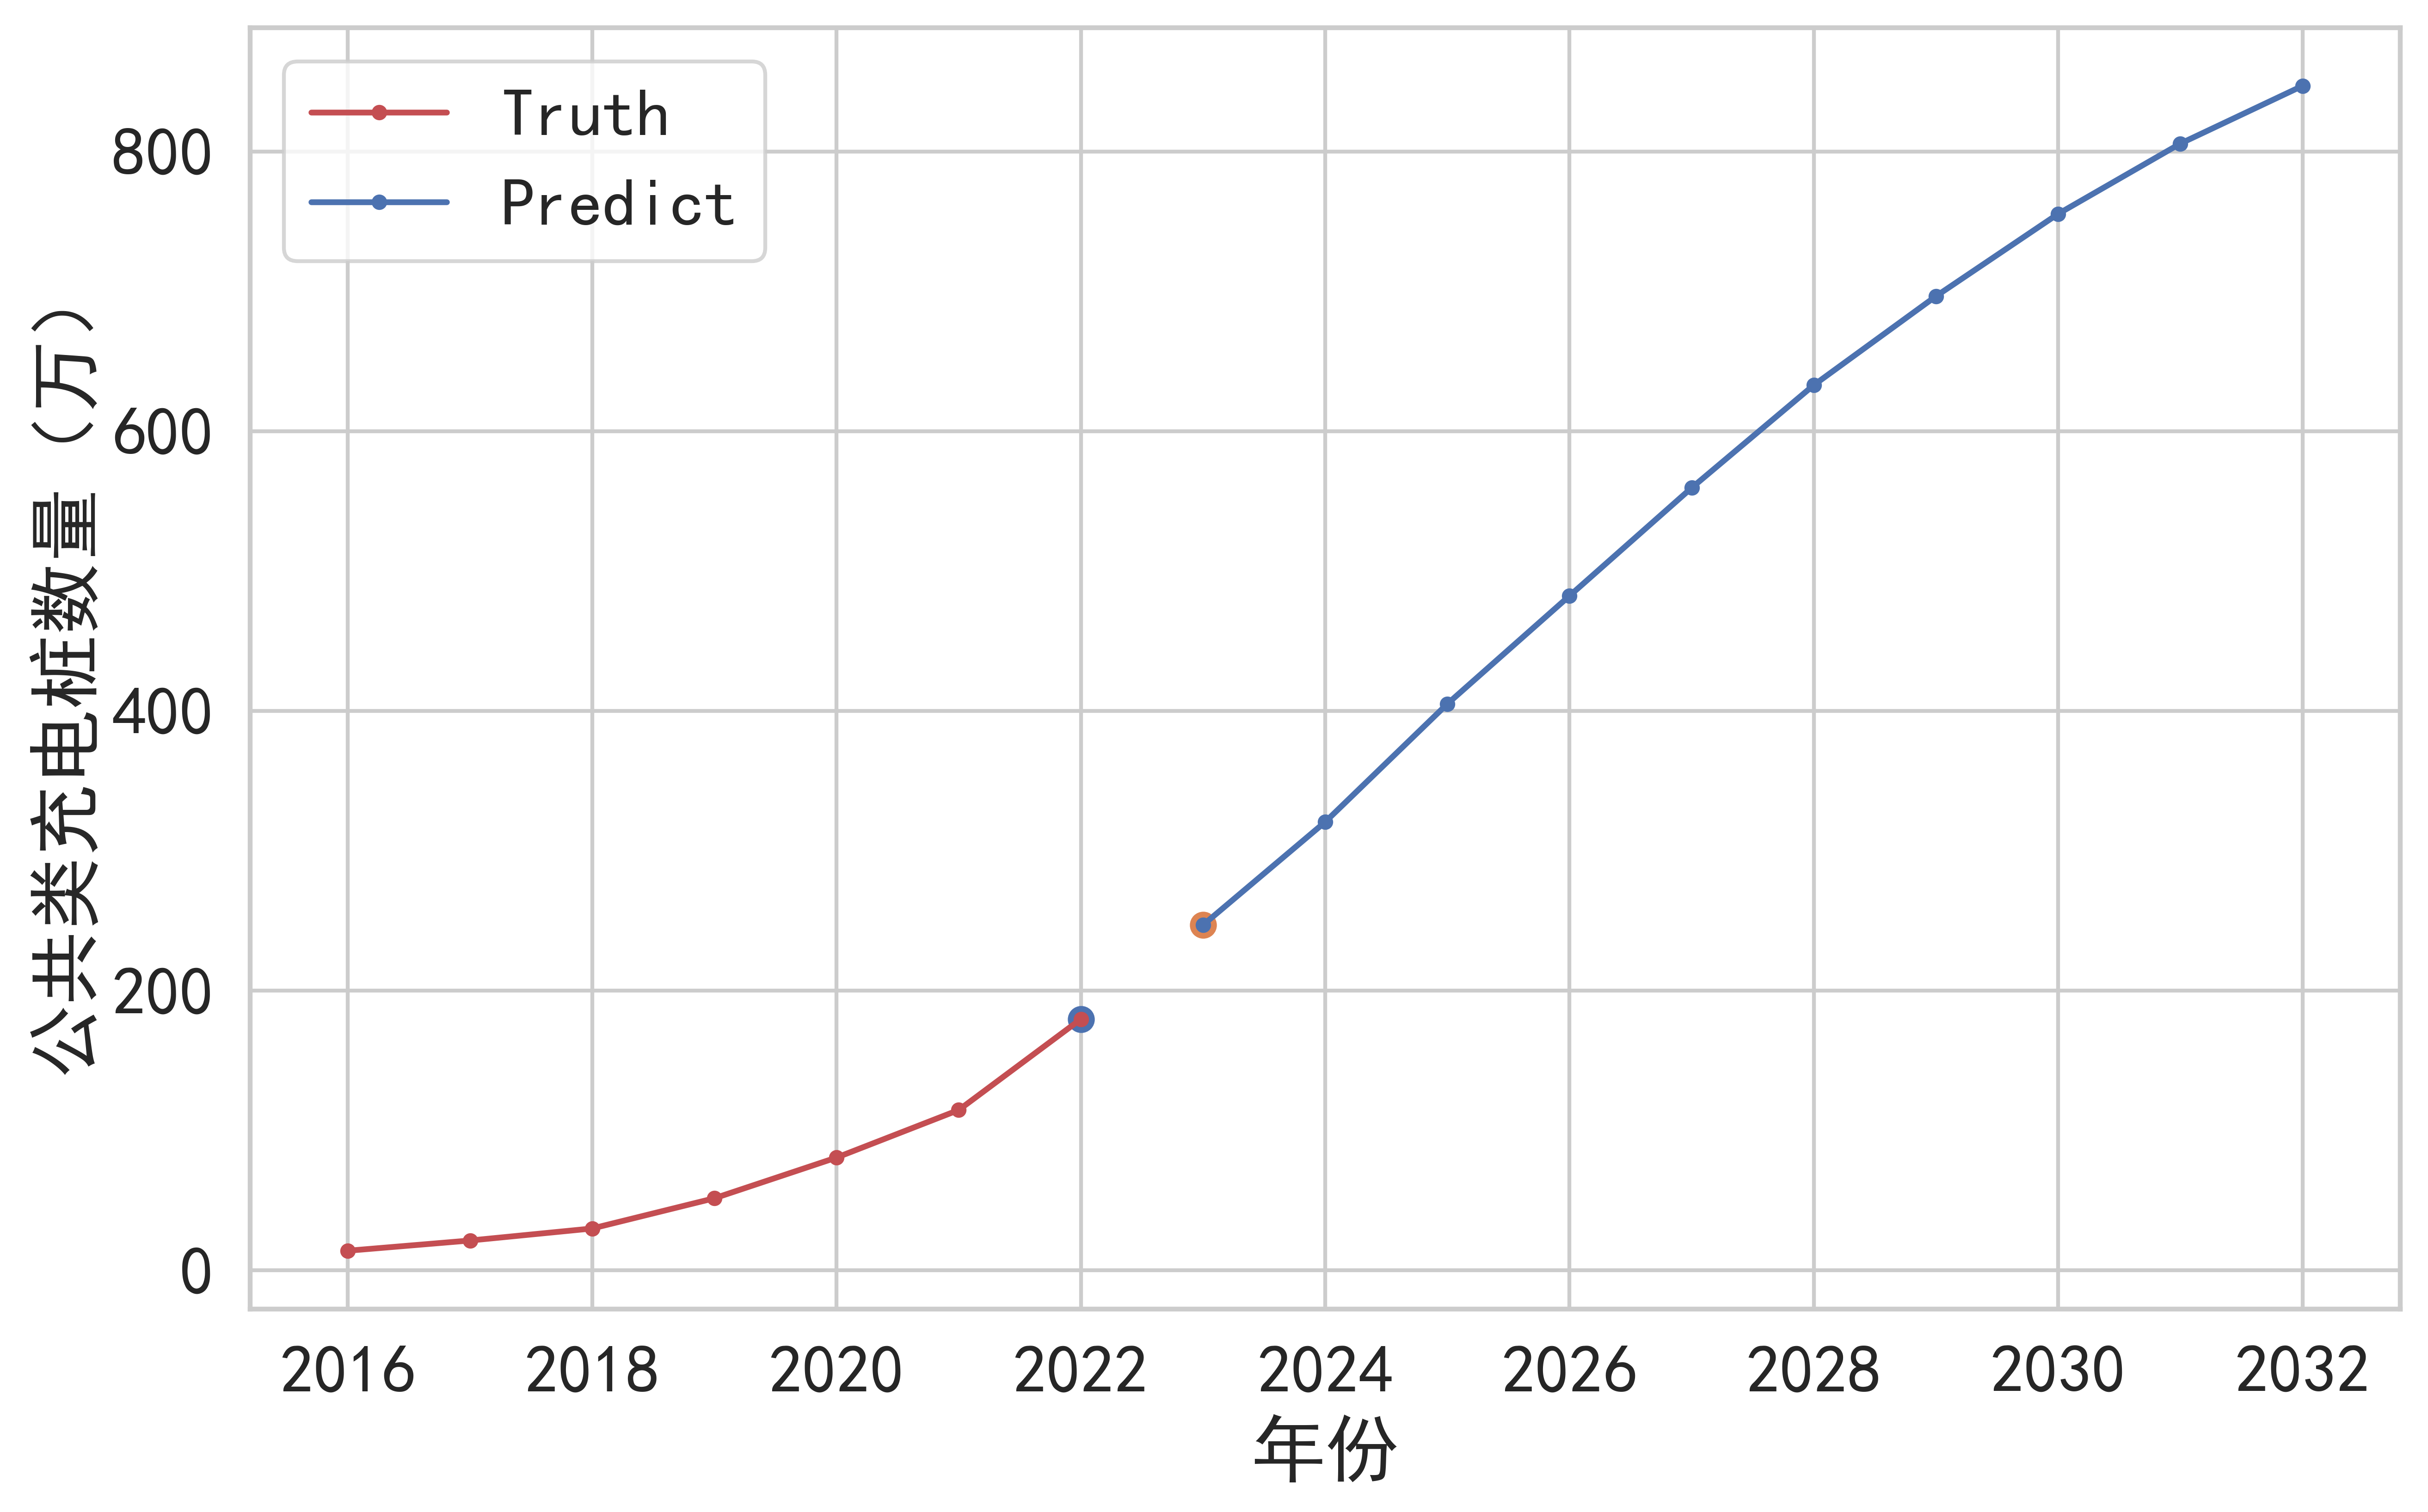

In [10]:
plt.figure(dpi=300,figsize=(10,6))
plt.plot(dataset.index,dataset.values, '-',label='Truth',linestyle='-',marker='.',color='r')
plt.scatter(dataset.index[-1],dataset.values[-1])

plt.plot(range(2023,2033),predictions[0],'--',label='Predict',linestyle='-',marker='.',color='b')
plt.scatter(2023,predictions[0][0])
plt.xlabel('年份')
plt.ylabel('公共类充电桩数量（万）')
plt.legend()
#plt.savefig('问题2\\充电站预测结果.png',dpi=500)
plt.show()